In [229]:
import torch
from torch import nn


In [230]:
torch.__version__

'2.4.0'

In [231]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [232]:
#get data
import requests
import zipfile
from pathlib import Path

data_path = Path('data')
image_path = data_path / 'pizza_steak_sushi'

if not image_path.exists():
    image_path.mkdir(parents=True, exist_ok=True)
else:
    print(f"{image_path} already exists")
    
# with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    # request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    # print("Downloading pizza, steak, suhsi data...")
    # f.write(request.content)
# with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    # print("Unzipping pizza, steak, suhsi data...")
    # zip_ref.extractall(image_path)

data/pizza_steak_sushi already exists


In [233]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There ara {len(dirnames)} directories and {len(filenames)} files in {dirpath}.")
        
walk_through_dir(image_path)

There ara 2 directories and 0 files in data/pizza_steak_sushi.
There ara 3 directories and 0 files in data/pizza_steak_sushi/test.
There ara 0 directories and 25 files in data/pizza_steak_sushi/test/pizza.
There ara 0 directories and 31 files in data/pizza_steak_sushi/test/sushi.
There ara 0 directories and 19 files in data/pizza_steak_sushi/test/steak.
There ara 3 directories and 0 files in data/pizza_steak_sushi/train.
There ara 0 directories and 78 files in data/pizza_steak_sushi/train/pizza.
There ara 0 directories and 72 files in data/pizza_steak_sushi/train/sushi.
There ara 0 directories and 75 files in data/pizza_steak_sushi/train/steak.


Random image path: data/pizza_steak_sushi/train/pizza/2330965.jpg
Image class: pizza | Image height: 512 | Image width: 512


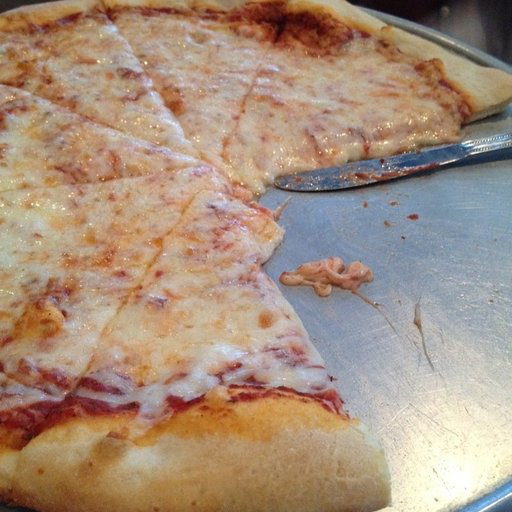

In [234]:
# Show Image method 1
import random 
from PIL import Image   

image_path_list = list(image_path.glob('*/*/*.jpg'))

random_image_path = random.choice(image_path_list)
random_image_class = random_image_path.parent.stem
img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f'Image class: {random_image_class} | Image height: {img.height} | Image width: {img.width}')
img

(-0.5, 511.5, 511.5, -0.5)

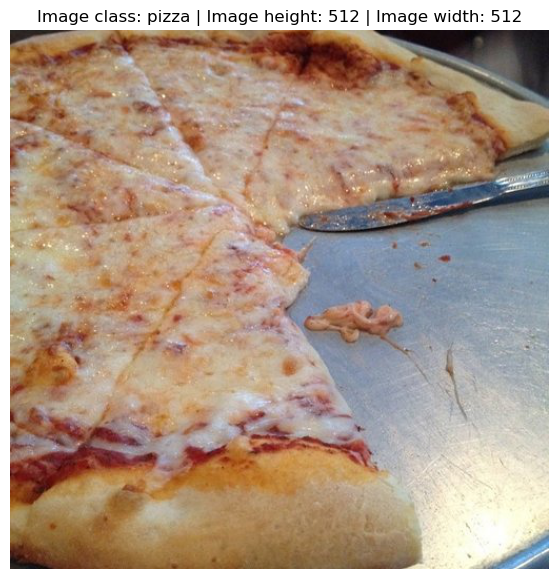

In [235]:
#Show Image method 2
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.array(img)

plt.figure(figsize=(10, 7))
#plt.imshow(img_as_array)
plt.imshow(img)
plt.title(f'Image class: {random_image_class} | Image height: {img.height} | Image width: {img.width}')
plt.axis('off')



In [236]:
import torch 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [237]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [238]:
def plot_transformed_images (image_path: list, transform, n=3, seed=None):
    if seed is not None:
        random.seed(seed)
    
    for image_path in random.sample(image_path, n):
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(img)
            ax[0].set_title(f'Original\nShape: {img.size}')
            ax[0].axis('off')
            
            transform_image = transform(img)
            ax[1].imshow(transform_image.permute(1,2,0))
            ax[1].set_title(f"Transformed\nShape: {transform_image.shape}")
            ax[1].axis('off')
            
            fig.suptitle(f"Class: {image_path.parent.stem}")

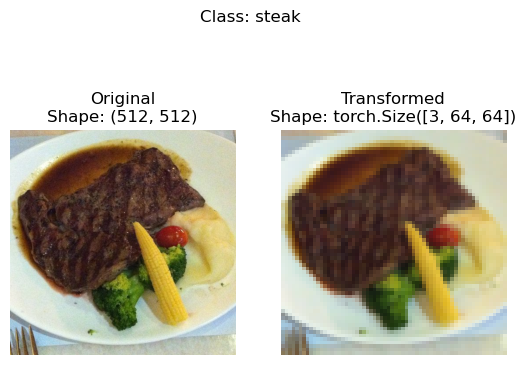

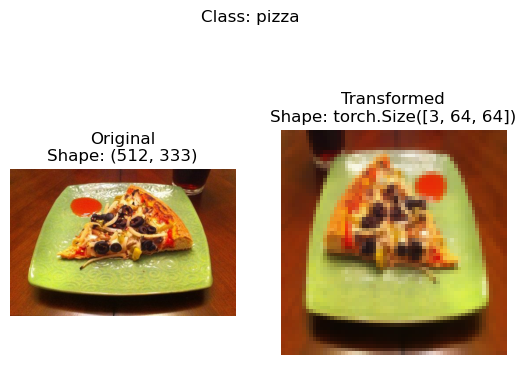

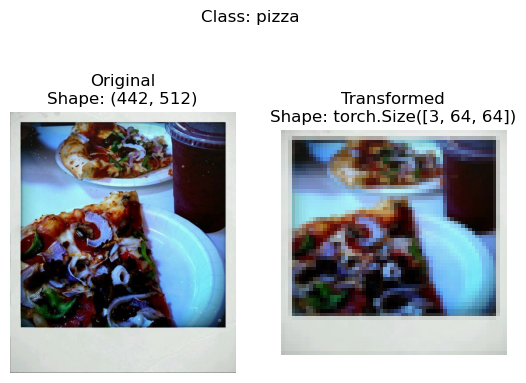

In [239]:
plot_transformed_images(image_path= image_path_list, transform=data_transform, n=3, seed=42)

In [240]:
from torchvision import datasets
train_dir = image_path / 'train'
test_dir = image_path / 'test'
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                transform=data_transform,
                                 target_transform=None)

In [241]:
# Custom Dataset 
def find_classed(directory):
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [262]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
    def __init__(self, directory, transform=None):
        self.paths = list(Path(directory).glob('**/*.jpg'))
        self.transform = transform
        self.classes, self.class_to_idx = find_classed(directory)
    def __len__(self):
        return len(self.paths)
    def load_image(self, index: int):
        image_path = self.paths[index]
        return Image.open(image_path)
    def __getitem__(self, index: int):
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        if self.transform is not None:
            img = self.transform(img)
            return img, class_idx
        else:
            return img, class_idx

In [263]:
train_data_custom = ImageFolderCustom(train_dir, transform=data_transform)
test_data_custom = ImageFolderCustom(test_dir, transform=data_transform)
len(test_data_custom)

75

In [268]:
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(train_data_custom, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader_custom = DataLoader(test_data_custom, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
img_custom, img_label_custom = next(iter(train_dataloader_custom))
img_custom.shape, img_label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

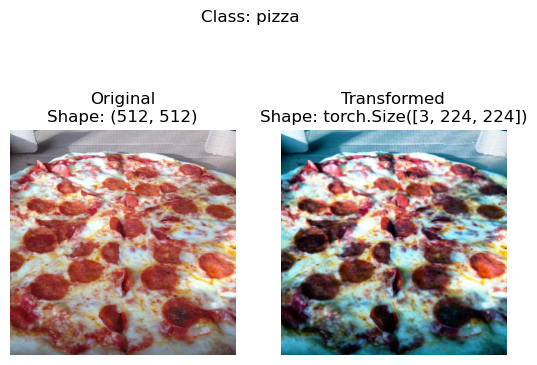

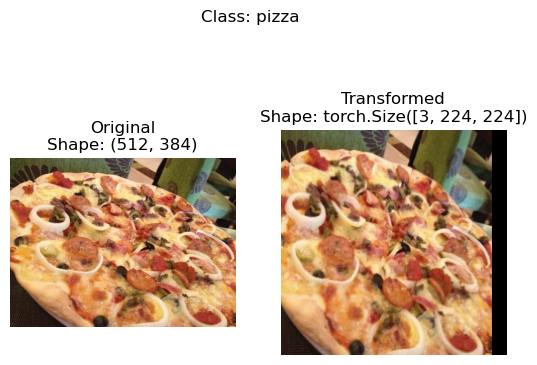

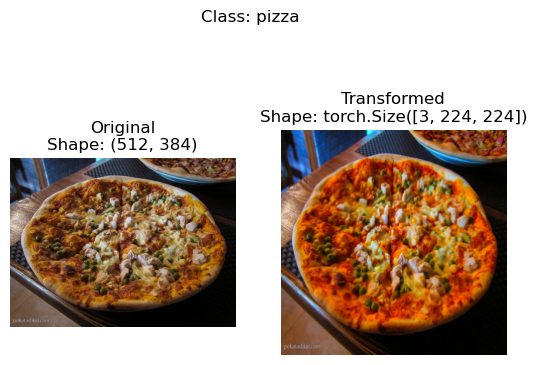

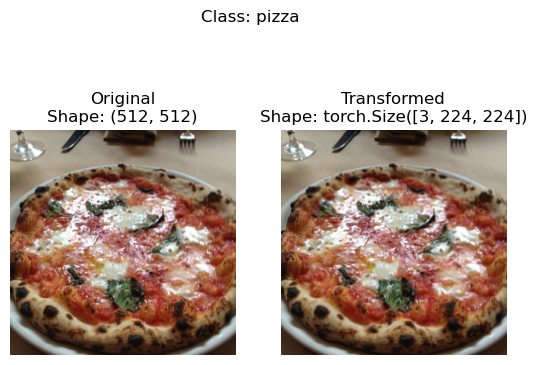

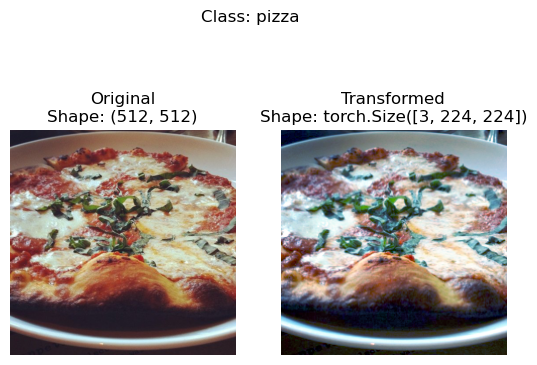

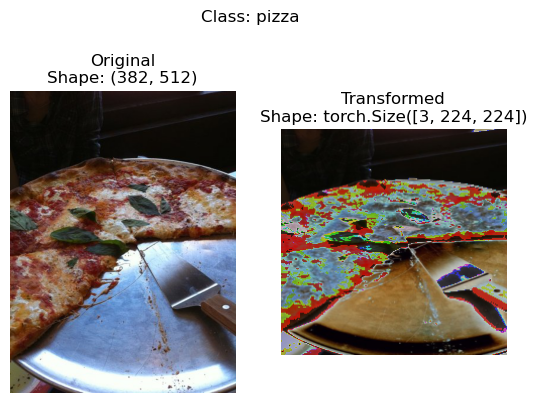

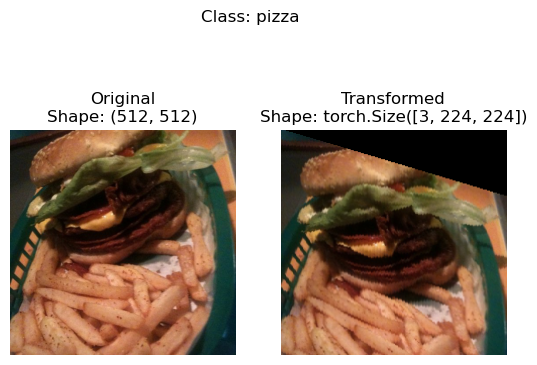

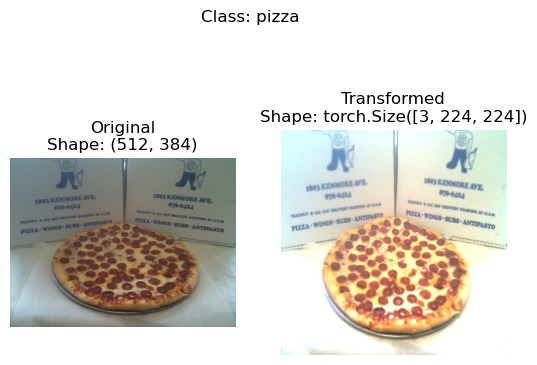

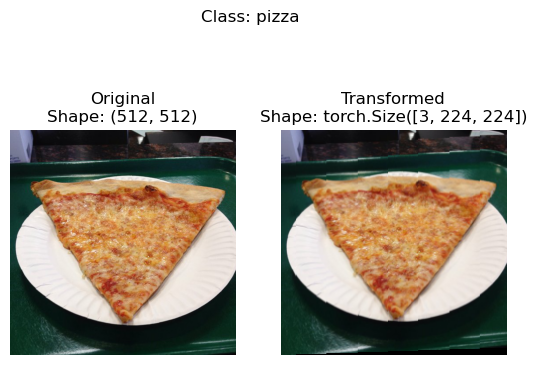

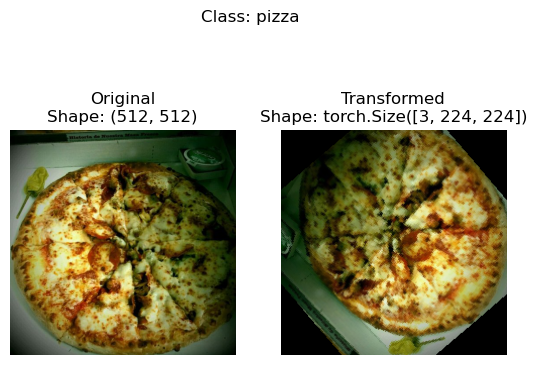

In [271]:
#data augmentation
train_transform_with_augmentation = transforms.Compose([transforms.Resize((224, 224)),
                                                        transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                                        transforms.ToTensor()
                                                        ])
plot_transformed_images(image_path= image_path_list[:10], transform=train_transform_with_augmentation,n=10, seed=42)